<a href="https://colab.research.google.com/github/mjxxkxx/Movie-Dataset_Analysis_Project/blob/main/Movie_Rating_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

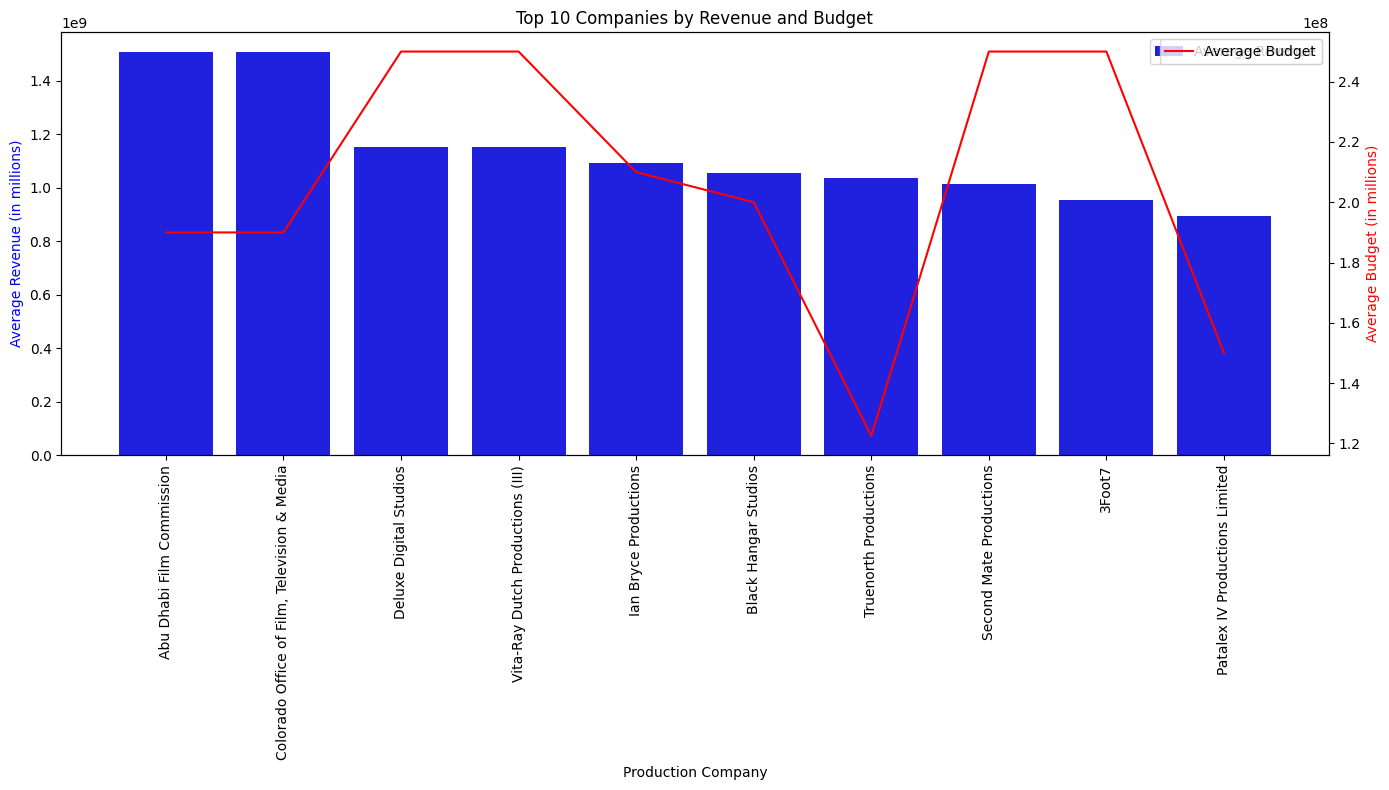

In [10]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
credits_path = '/content/drive/MyDrive/dataset_miniproject/credits.csv'
keywords_path = '/content/drive/MyDrive/dataset_miniproject/keywords.csv'
links_path = '/content/drive/MyDrive/dataset_miniproject/links.csv'
movies_metadata_path = '/content/drive/MyDrive/dataset_miniproject/movies_metadata.csv'
ratings_path = '/content/drive/MyDrive/dataset_miniproject/ratings.csv'

# Data Loading
movies_metadata_df = pd.read_csv(movies_metadata_path, low_memory=False)
ratings_df = pd.read_csv(ratings_path)
credits_df = pd.read_csv(credits_path)
keywords_df = pd.read_csv(keywords_path)
links_df = pd.read_csv(links_path)

# Data Cleaning and Preparation
movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')
movies_metadata_df['release_year'] = movies_metadata_df['release_date'].dt.year
movies_metadata_df['release_month'] = movies_metadata_df['release_date'].dt.month
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')
movies_metadata_df['revenue'] = pd.to_numeric(movies_metadata_df['revenue'], errors='coerce')
movies_metadata_df['popularity'] = pd.to_numeric(movies_metadata_df['popularity'], errors='coerce')

# Helper function to extract company names and genres
def extract_company_names(x):
    if pd.isna(x) or isinstance(x, bool) or not isinstance(x, str):  # Check for NaN, boolean, and non-string types
        return []
    try:
        companies = ast.literal_eval(x)
        if isinstance(companies, list):  # Ensure it's a list
            return [company['name'] for company in companies if isinstance(company, dict) and 'name' in company]
    except (ValueError, SyntaxError):
        return []
    return []

def extract_genres(genre_list):
    if isinstance(genre_list, str):
        try:
            genres = ast.literal_eval(genre_list)
            return [genre['name'] for genre in genres]
        except (ValueError, SyntaxError):
            return []
    return []

# Applying the functions
movies_metadata_df['genres_list'] = movies_metadata_df['genres'].apply(extract_genres)
movies_metadata_df['company_list'] = movies_metadata_df['production_companies'].apply(extract_company_names)

# 제작사별 성과 분석 함수
def calculate_company_performance():
    company_performance = movies_metadata_df.explode('company_list').groupby('company_list').agg({
        'revenue': 'mean',
        'budget': 'mean',
        'popularity': 'mean',
        'vote_average': 'mean'
    }).dropna().sort_values(by='revenue', ascending=False)

    return company_performance

# 시각화 1: 제작사별 평균 수익 및 제작비
def plot_company_revenue_and_budget():
    company_performance = calculate_company_performance().head(10)

    plt.figure(figsize=(14, 8))

    sns.barplot(x=company_performance.index, y=company_performance['revenue'], color='b', label='Average Revenue')
    sns.barplot(x=company_performance.index, y=company_performance['budget'], color='r', label='Average Budget')

    plt.title('Top 10 Companies by Average Revenue and Budget')
    plt.xlabel('Production Company')
    plt.ylabel('Amount (in millions)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 시각화 2: 제작사별 인기도와 평점
def plot_company_popularity_and_ratings():
    company_performance = calculate_company_performance().head(10)

    fig, ax1 = plt.subplots(figsize=(14, 8))

    sns.barplot(x=company_performance.index, y=company_performance['popularity'], ax=ax1, color='g', label='Popularity')
    ax1.set_xlabel('Production Company')
    ax1.set_ylabel('Popularity')
    ax1.set_title('Top 10 Companies by Popularity and Vote Average')
    ax1.tick_params(axis='x', rotation=90)

    ax2 = ax1.twinx()
    sns.lineplot(x=company_performance.index, y=company_performance['vote_average'], ax=ax2, color='r', label='Vote Average')
    ax2.set_ylabel('Vote Average')

    fig.tight_layout()
    plt.show()

# 시각화 3: 제작사별 통합 성과 분석
def plot_company_performance_combined():
    company_performance = calculate_company_performance().head(10)

    fig, ax1 = plt.subplots(figsize=(14, 8))

    sns.barplot(x=company_performance.index, y=company_performance['revenue'], ax=ax1, color='b', label='Average Revenue')
    ax1.set_xlabel('Production Company')
    ax1.set_ylabel('Average Revenue (in millions)', color='b')
    ax1.tick_params(axis='x', rotation=90)

    ax2 = ax1.twinx()
    sns.lineplot(x=company_performance.index, y=company_performance['budget'], ax=ax2, color='r', label='Average Budget')
    ax2.set_ylabel('Average Budget (in millions)', color='r')

    plt.title('Top 10 Companies by Revenue and Budget')
    fig.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    #plot_company_revenue_and_budget()
    # plot_company_popularity_and_ratings()
    plot_company_performance_combined()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = ['budget', 'popularity', 'vote_average', 'release_year']
X = movies_metadata_df[features]
y = movies_metadata_df['revenue']

X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 1626365933348878.0
R² Score: 0.656306458406066


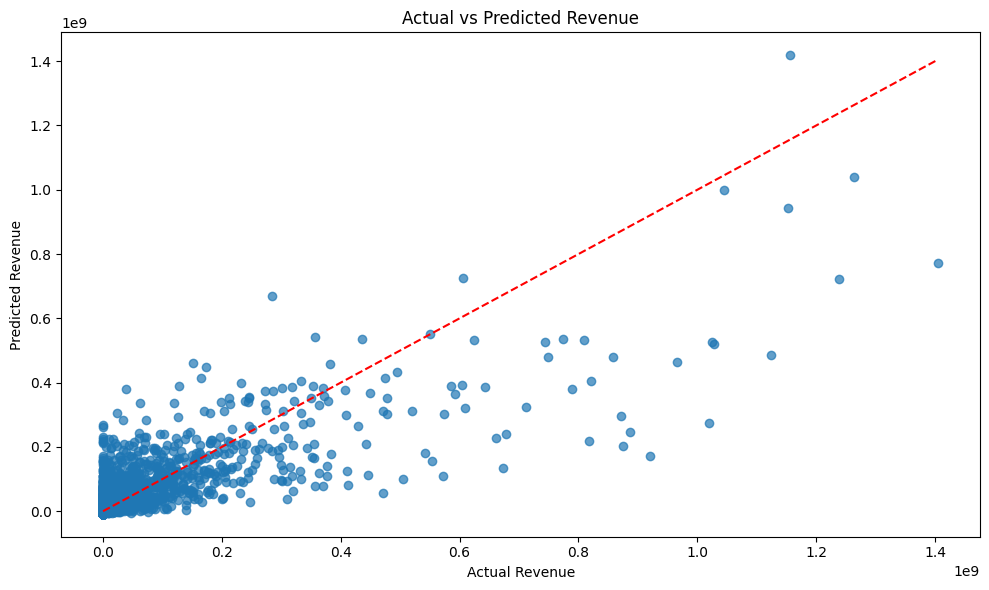

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.tight_layout()
plt.show()